In [3]:
# Required Imports 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import json
import datetime, time
from matplotlib.dates import date2num
from scipy.interpolate import make_interp_spline
import argparse
import re
import sys
import matplotlib.ticker as ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

In [4]:
# https://stackoverflow.com/a/1879011/14626757
# Returns a walked path under collected_data
def f(starting_path):
  alld = {'': {}}

  for dirpath, dirnames, filenames in os.walk(starting_path):
    d = alld
    dirpath = dirpath[len(starting_path):]
    for subd in dirpath.split(os.sep):
      based = d
      d = d[subd]
    if dirnames:
      for dn in dirnames:
        d[dn] = {}
    else:
      based[subd] = filenames
  return alld['']

  # standard code to convert data to a timestamp, metric list 
def convert_enddate_to_seconds(ts):
    """Takes ISO 8601 format(string) and converts into epoch time."""
    dt = datetime.datetime.strptime(ts[:-7],'%Y-%m-%dT%H:%M:%S')+\
                datetime.timedelta(hours=int(ts[-5:-3]),
                minutes=int(ts[-2:]))*int(ts[-6:-5]+'1')
    seconds = time.mktime(dt.timetuple()) + dt.microsecond/1000000.0
    return seconds

def convert_to_json(filename):
    # Opening JSON file
    f = open(filename)
    
    # returns JSON object as
    # a dictionary
    data = json.load(f)

    # Closing file
    f.close()
    return data

# returns 2 lists for average values, and timestamp
def get_list(timeseries):
    y = [val['average'] for val in timeseries]
    x = [pd.to_datetime(convert_enddate_to_seconds(val['timeStamp']),unit='s') for val in timeseries]
    return x,y

# 
def return_time_metric(filename):
    data = convert_to_json(filename)
    timespan = data['timespan']
    time_interval = data['interval']
    value = data['value'][0]
    name_of_graph = value['name']['value']
    timeseries = value['timeseries'][0]['data']
    x, y = get_list(timeseries)
    return x,y

def create_graph(x,y,):
    # def clean_plot(data, metric):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(x, y)   # 2021-12-31T18:36:00+00:00 2021-12-31T19:05:00+00:00

def tolerant_mean(arrs): #https://stackoverflow.com/questions/10058227/calculating-mean-of-arrays-with-different-lengths
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [5]:
filepath = "../collected_data/watermelon"
api      = os.path.join(filepath, "api")
machine  = os.path.join(filepath, "machine")

api_listing     = f(api)
machine_listing = f(machine)


CPU Usage

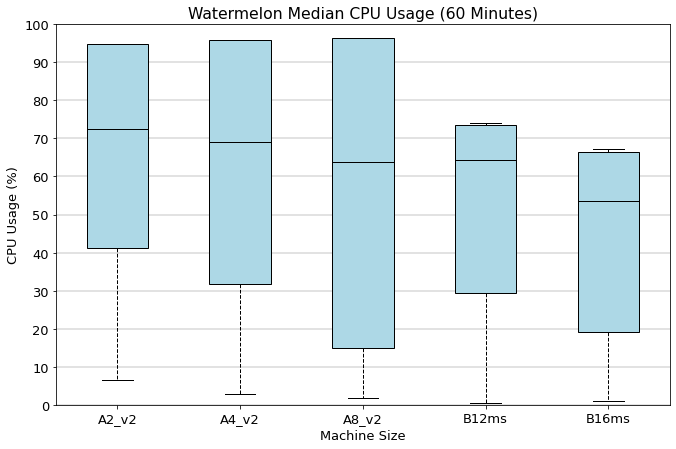

In [7]:
all_cleaned_metrics = []
for size, iteration in machine_listing.items():
    metrics   = []
    timestamp = 0
    for iteration, files in iteration.items(): 
        temp_path = os.path.join(machine, size, iteration)
        timestamp, metric = return_time_metric(os.path.join(temp_path, "percentageCPU.json"))
        metrics.append(metric)

    all_metrics = []
    for n in metrics:
        all_metrics.append([float(x) for x in n if x != None])
    mean_metrics , c = tolerant_mean(all_metrics)
    all_cleaned_metrics.append(mean_metrics)
        
fig = plt.figure(figsize =(11, 7))
ax = fig.add_subplot(111)
plt.boxplot(all_cleaned_metrics, patch_artist=True,  
            boxprops=dict(facecolor="lightblue", color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black", linestyle='--',),
            flierprops=dict(color="black", markeredgecolor="black"),
            medianprops=dict(color="Black")) 

labels = [f"{list(machine_listing.keys())[i][9:]}" for i in range(0, len(list(machine_listing.keys())))]
ax.set_xticklabels(labels)
ax.set(xlabel='Machine Size',
           ylabel='CPU Usage (%)',
           title='Watermelon Median CPU Usage (60 Minutes)')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.45, alpha=1)
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.show()

Memory Usage

In [8]:
def convert_size(bytes, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a['g']):
        r = r / bsize

    return(r)



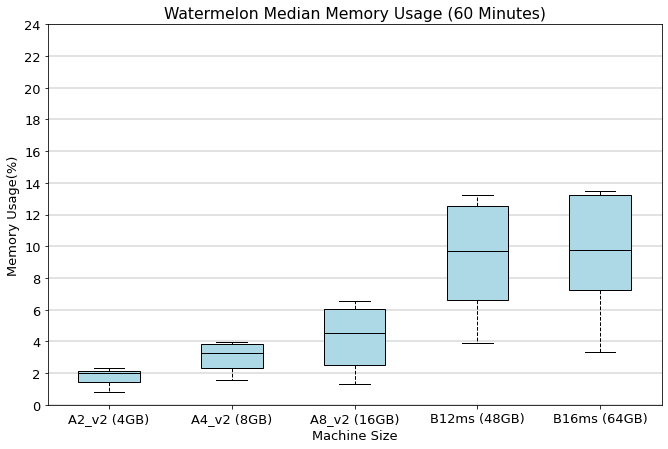

In [10]:
all_cleaned_metrics = []
machine_sizes_mem = [4,8,16,48,64]
n_iter = 0

for size, iteration in machine_listing.items():
    metrics   = []
    timestamp = 0
    for iteration, files in iteration.items(): 
        temp_path = os.path.join(machine, size, iteration)
        timestamp, metric = return_time_metric(os.path.join(temp_path, "availableMemoryBytes.json"))
        metrics.append(metric)
    
    # get used instead of available 
    all_metrics = []
    for n in metrics:
        all_metrics.append([machine_sizes_mem[n_iter] - convert_size(float(x)) for x in n if x != None])
    n_iter += 1
    mean_metrics , c = tolerant_mean(all_metrics)
    all_cleaned_metrics.append(mean_metrics)
    
# Graph Settings 
fig = plt.figure(figsize =(11, 7))
ax = fig.add_subplot(111)
plt.boxplot(all_cleaned_metrics, patch_artist=True,  
            boxprops=dict(facecolor="lightblue", color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black", linestyle='--',),
            flierprops=dict(color="black", markeredgecolor="black"),
            medianprops=dict(color="Black")) 

ax.set_xticklabels(list(machine_listing.keys()))
labels = [f"{list(machine_listing.keys())[i][9:]} ({machine_sizes_mem[i]}GB)" for i in range(0, len(list(machine_listing.keys())))]
ax.set_xticklabels(labels)


ax.set(xlabel='Machine Size',
           ylabel='Memory Usage(%)',
           title='Watermelon Median Memory Usage (60 Minutes)')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.45, alpha=1)
plt.yticks(np.arange(0, 27, 2))
plt.ylim(0, 24) # Kept at 25


plt.show()

Latency Percentile

In [17]:
regex = re.compile(r'\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)')
filename = re.compile(r'(.*/)?([^.]*)(\.\w+\d+)?')

def parse_percentiles( file ):
    lines       = [ line for line in open(file) if re.match(regex, line)]
    values      = [ re.findall(regex, line)[0] for line in lines]
    pctles      = [ (float(v[0]), float(v[1]), int(v[2]), 
                     float(v[3])) for v in values]
    percentiles = pd.DataFrame(pctles, columns=['Latency', 'Percentile', 'TotalCount', 'inv-pct'])
    return percentiles


def parse_files( files ):
    return [ parse_percentiles(file) for file in files]


def info_text(name, data):
    textstr = '%-18s\n------------------\n%-6s = %6.2f ms\n%-6s = %6.2f ms\n%-6s = %6.2f ms\n'%(
        name,
        "min",    data['Latency'].min(),
        "median", data.iloc[(data['Percentile'] - 0.5).abs().argsort()[:1]]['Latency'],
        "max",    data['Latency'].max())
    return textstr


def info_box(ax, text):
    props = dict(boxstyle='round', facecolor='lightcyan', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
        verticalalignment='top', bbox=props, fontname='monospace')


def plot_summarybox( ax, percentiles, labels ):
    # add info box to the side
    textstr = '\n'.join([info_text(labels[i], percentiles[i]) for i in range(len(labels))])
    info_box(ax, textstr)

def clean_y(x, pos):
    return int(x/1000)
def plot_percentiles( all_percentiles, all_latency, title, labels):
    fig, ax = plt.subplots(figsize=(16,8))
    
    # plot values
    for i in range(0, len(all_percentiles)):
        ax.plot(all_percentiles[i], all_latency[i])
    # set axis and legend
    ax.grid()
    
    ticks_y = ticker.FuncFormatter(clean_y)
    ax.yaxis.set_major_formatter(ticks_y)
    
    ax.set(xlabel='Percentile',
           ylabel='Latency (milliseconds)',
           title=f'{title} Median Latency Percentiles (lower is better) ')
    ax.set_xscale('logit')
    plt.xticks([0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999])
    majors = ["25%", "50%", "90%", "99%", "99.9%", "99.99%", "99.999%", "99.9999%"]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    
    
    labels = [f"{list(machine_listing.keys())[i][9:]}" for i in range(0, len(list(machine_listing.keys())))]
    plt.legend(bbox_to_anchor=(-0.1, 1.02, 1., .102),
               loc=3, ncol=2,  borderaxespad=0., 
              labels = labels)

    return fig, ax

def plot_percentile( x, y  ):
    fig, ax = plt.subplots(figsize=(16,8))
        # plot values
    
    ax.plot(x, y)

    # set axis and legend
    ax.grid()
    ax.set(xlabel='Percentile',
           ylabel='Latency (milliseconds)',
           title='Latency Percentiles (lower is better)')
    ax.set_xscale('logit')
    plt.xticks([0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999])
    majors = ["25%", "50%", "90%", "99%", "99.9%", "99.99%", "99.999%", "99.9999%"]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
               loc=3, ncol=2,  borderaxespad=0.)

    return fig, ax


(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Watermelon Median Latency Percentiles (lower is better) '}, xlabel='Percentile', ylabel='Latency (milliseconds)'>)

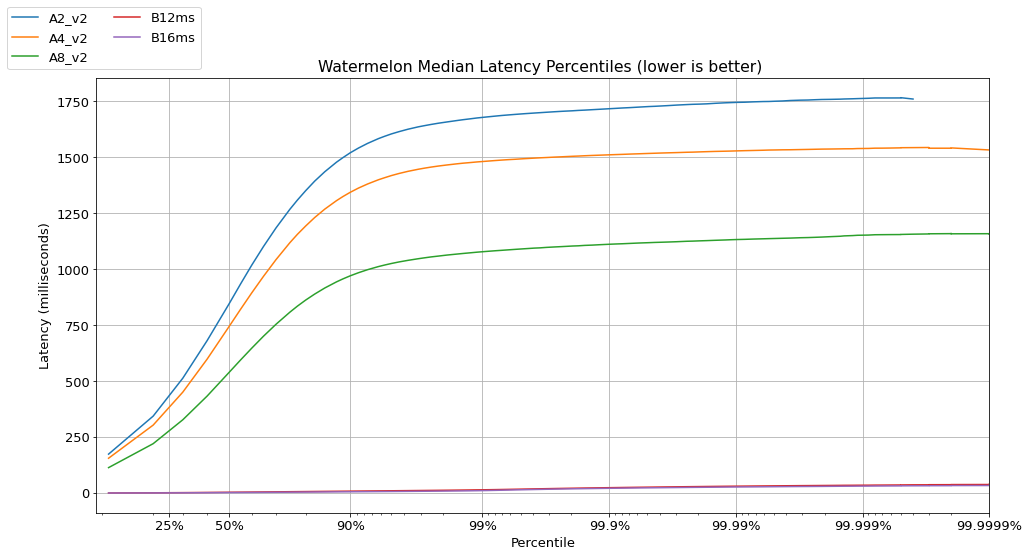

In [18]:
all_percentiles = []
all_latency     = []
for size, iteration in api_listing.items():
    latency     = []
    percentiles = []

    for i, files in iteration.items(): 
        temp_path = os.path.join(api, size, i)
        file_name = "load.txt"
        
        percentile = parse_percentiles(os.path.join(temp_path, file_name))
        percentiles.append(list(percentile['Percentile']))
        latency.append(list(percentile['Latency']))
             
 
    x, err= tolerant_mean(percentiles)
    y, y_err = tolerant_mean(latency)
    all_percentiles.append(x)
    all_latency.append(y)

plot_percentiles( all_percentiles, all_latency, "Watermelon", list(api_listing.keys()))
